In [1]:
!pip install pydicom
!pip install git+https://github.com/facebookresearch/fvcore.git
!pip install torchsummary

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-01zym1b5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-01zym1b5
  Resolved https://github.com/facebookresearch/fvcore.git to commit d051804c97dfd7c8f349996fefd8644fe2955bc2
  Preparing metadata (setup.py) ... done


In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import logging
import warnings
import random
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary
from tqdm import tqdm

In [3]:
pydicom_logger = logging.getLogger("pydicom")
pydicom_logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, module="pydicom")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class ISPY1Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.subjects = sorted(os.listdir(root_dir))
        self.transform = transform

    def __len__(self):
        return len(self.subjects) * 4

    def load_dicom_images(self, dicom_dir):
        slices = [pydicom.dcmread(os.path.join(dicom_dir, f)) for f in os.listdir(dicom_dir)]
        slices_array = np.stack([s.pixel_array for s in slices], axis=0)
        return slices_array.astype(np.float32) / np.max(slices_array)

    def __getitem__(self, idx):
        subject_idx = idx // 4
        sample_type = idx % 4

        subject_path = os.path.join(self.root_dir, self.subjects[subject_idx])
        time_stages = ['T1', 'T2', 'T3', 'T4']
        correct_order = []

        for stage in time_stages:
            dicom_dir = os.path.join(subject_path, stage)
            image_stack = self.load_dicom_images(dicom_dir)
            resized_stack = np.stack([
                F.resize(torch.tensor(slice)[None, ...], (256, 256)).squeeze(0)
                for slice in image_stack
            ], axis=0)
            correct_order.append(resized_stack)

        if sample_type == 0:
            shuffled_order = correct_order
        else:
            shuffled_order = correct_order.copy()
            random.shuffle(shuffled_order)

        label = np.stack(correct_order, axis=0)
        if self.transform:
            label = self.transform(label)

        sample = np.stack(shuffled_order, axis=0)
        if self.transform:
            sample = self.transform(sample)

        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.float)

In [6]:
dataset = ISPY1Dataset(root_dir='/content/drive/MyDrive/ISPY1_sub')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

In [7]:
for i in range(len(dataset)):
    sample, label = dataset[i]
    print(f'Sample {i} shape: {sample.shape}, label shape: {label.shape}')

Sample 0 shape: torch.Size([4, 60, 256, 256]), label shape: torch.Size([4, 60, 256, 256])
Sample 1 shape: torch.Size([4, 60, 256, 256]), label shape: torch.Size([4, 60, 256, 256])
Sample 2 shape: torch.Size([4, 60, 256, 256]), label shape: torch.Size([4, 60, 256, 256])
Sample 3 shape: torch.Size([4, 60, 256, 256]), label shape: torch.Size([4, 60, 256, 256])
Sample 4 shape: torch.Size([4, 60, 256, 256]), label shape: torch.Size([4, 60, 256, 256])
Sample 5 shape: torch.Size([4, 60, 256, 256]), label shape: torch.Size([4, 60, 256, 256])
Sample 6 shape: torch.Size([4, 60, 256, 256]), label shape: torch.Size([4, 60, 256, 256])
Sample 7 shape: torch.Size([4, 60, 256, 256]), label shape: torch.Size([4, 60, 256, 256])
Sample 8 shape: torch.Size([4, 60, 256, 256]), label shape: torch.Size([4, 60, 256, 256])
Sample 9 shape: torch.Size([4, 60, 256, 256]), label shape: torch.Size([4, 60, 256, 256])
Sample 10 shape: torch.Size([4, 60, 256, 256]), label shape: torch.Size([4, 60, 256, 256])
Sample 11

In [8]:
model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=False)
model.blocks[0].conv = nn.Conv3d(
    in_channels=4,
    out_channels=model.blocks[0].conv.out_channels,
    kernel_size=model.blocks[0].conv.kernel_size,
    stride=model.blocks[0].conv.stride,
    padding=model.blocks[0].conv.padding,
    bias=model.blocks[0].conv.bias is not None
)

class SlowR50Reconstructor(nn.Module):
    def __init__(self, base_model):
        super(SlowR50Reconstructor, self).__init__()
        self.encoder = nn.Sequential(*list(base_model.blocks[:-3]))
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(512, 256, kernel_size=3, stride=(1, 2, 2), padding=1, output_padding=(0, 1, 1)),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.ConvTranspose3d(256, 64, kernel_size=3, stride=(1, 2, 2), padding=1, output_padding=(0, 1, 1)),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 4, kernel_size=3, stride=(1, 2, 2), padding=1, output_padding=(0, 1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = SlowR50Reconstructor(model)
model.to(device)
summary(model, input_size=(4, 60, 256, 256), device=str(device))

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 60, 128, 128]          12,544
       BatchNorm3d-2     [-1, 64, 60, 128, 128]             128
              ReLU-3     [-1, 64, 60, 128, 128]               0
         MaxPool3d-4       [-1, 64, 60, 64, 64]               0
   ResNetBasicStem-5       [-1, 64, 60, 64, 64]               0
            Conv3d-6      [-1, 256, 60, 64, 64]          16,384
       BatchNorm3d-7      [-1, 256, 60, 64, 64]             512
            Conv3d-8       [-1, 64, 60, 64, 64]           4,096
       BatchNorm3d-9       [-1, 64, 60, 64, 64]             128
             ReLU-10       [-1, 64, 60, 64, 64]               0
           Conv3d-11       [-1, 64, 60, 64, 64]          36,864
      BatchNorm3d-12       [-1, 64, 60, 64, 64]             128
             ReLU-13       [-1, 64, 60, 64, 64]               0
           Conv3d-14      [-1, 256, 60,

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, label in tqdm(dataloader):  # Only need inputs, as labels are not needed for reconstruction
        inputs, label = inputs.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # The model should reconstruct the input in the correct order

        # Calculate reconstruction loss between outputs and inputs
        loss = criterion(outputs, label)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')
    losses.append(running_loss/len(dataloader))


100%|██████████| 81/81 [08:01<00:00,  5.95s/it]


Epoch 1, Loss: 0.0842051825221674


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 2, Loss: 0.024077059574609185


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 3, Loss: 0.011239093613385417


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 4, Loss: 0.0069684467140447215


100%|██████████| 81/81 [08:01<00:00,  5.94s/it]


Epoch 5, Loss: 0.005050126161357319


100%|██████████| 81/81 [08:01<00:00,  5.94s/it]


Epoch 6, Loss: 0.004136778422872777


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 7, Loss: 0.0036633149979429114


100%|██████████| 81/81 [08:01<00:00,  5.94s/it]


Epoch 8, Loss: 0.003361533758127027


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 9, Loss: 0.003170739888087099


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 10, Loss: 0.003045928402930314


100%|██████████| 81/81 [08:00<00:00,  5.94s/it]


Epoch 11, Loss: 0.0029587614778314292


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 12, Loss: 0.002911370765003893


100%|██████████| 81/81 [07:59<00:00,  5.91s/it]


Epoch 13, Loss: 0.002893152834997041


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 14, Loss: 0.002826157023118418


100%|██████████| 81/81 [08:01<00:00,  5.94s/it]


Epoch 15, Loss: 0.002807272257524784


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 16, Loss: 0.002757813607595493


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 17, Loss: 0.002769696146801666


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 18, Loss: 0.0027462879618353865


100%|██████████| 81/81 [07:58<00:00,  5.90s/it]


Epoch 19, Loss: 0.0027187504420447864


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 20, Loss: 0.0027052400185278167


100%|██████████| 81/81 [08:00<00:00,  5.94s/it]


Epoch 21, Loss: 0.0026973174528483255


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 22, Loss: 0.002695286024166386


100%|██████████| 81/81 [08:00<00:00,  5.94s/it]


Epoch 23, Loss: 0.0026589742068339277


100%|██████████| 81/81 [07:58<00:00,  5.91s/it]


Epoch 24, Loss: 0.0026465131912702397


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 25, Loss: 0.0026456486522852454


100%|██████████| 81/81 [07:58<00:00,  5.91s/it]


Epoch 26, Loss: 0.002631964005334418


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 27, Loss: 0.002647535753275417


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 28, Loss: 0.00265066514659765


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 29, Loss: 0.0026161564976827784


100%|██████████| 81/81 [08:00<00:00,  5.94s/it]


Epoch 30, Loss: 0.002612722182450931


100%|██████████| 81/81 [08:05<00:00,  5.99s/it]


Epoch 31, Loss: 0.0026361193510784225


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 32, Loss: 0.0025935554158310462


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 33, Loss: 0.0025932275716008413


100%|██████████| 81/81 [07:58<00:00,  5.91s/it]


Epoch 34, Loss: 0.002573534806063514


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 35, Loss: 0.002598316545230279


100%|██████████| 81/81 [07:58<00:00,  5.91s/it]


Epoch 36, Loss: 0.0025956352215467226


100%|██████████| 81/81 [07:58<00:00,  5.91s/it]


Epoch 37, Loss: 0.0026018282637161054


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 38, Loss: 0.0025701961123648985


100%|██████████| 81/81 [08:01<00:00,  5.94s/it]


Epoch 39, Loss: 0.002591545479429633


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 40, Loss: 0.002552835187403324


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 41, Loss: 0.0025492845085897933


100%|██████████| 81/81 [08:00<00:00,  5.94s/it]


Epoch 42, Loss: 0.0025448029182483386


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 43, Loss: 0.002554137749815889


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 44, Loss: 0.0025322472972703386


100%|██████████| 81/81 [08:01<00:00,  5.94s/it]


Epoch 45, Loss: 0.002557977009277193


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 46, Loss: 0.0025497905487470605


100%|██████████| 81/81 [07:59<00:00,  5.93s/it]


Epoch 47, Loss: 0.0025401677358550608


100%|██████████| 81/81 [07:59<00:00,  5.92s/it]


Epoch 48, Loss: 0.002572973419762688


100%|██████████| 81/81 [08:00<00:00,  5.93s/it]


Epoch 49, Loss: 0.0025522692551560424


100%|██████████| 81/81 [08:00<00:00,  5.94s/it]

Epoch 50, Loss: 0.002534302483301288


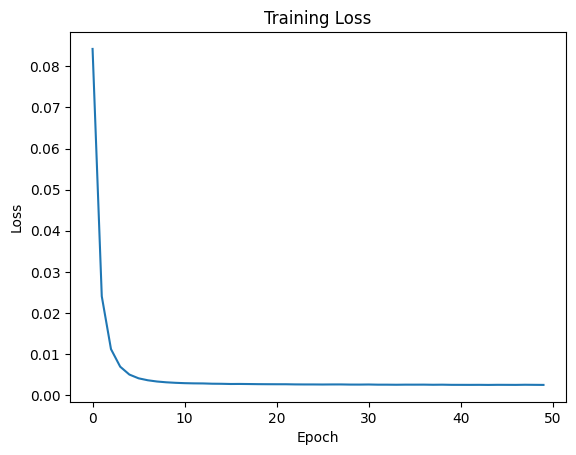

In [10]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [11]:
save_path = '/content/drive/MyDrive/model_reconstruction.pth'
torch.save(model.state_dict(), save_path)